In [12]:
import tensorflow as tf
import numpy as np
from scipy.stats import qmc

# --- Model Components ---
class CharacteristicLayer(tf.keras.layers.Layer):
    def __init__(self, min_wave_speed, max_wave_speed):
        if min_wave_speed >= max_wave_speed:
            raise ValueError("min_wave_speed must be less than max_wave_speed")
        super(CharacteristicLayer, self).__init__()
        self.snn = self.add_weight(
            shape=(),
            initializer=tf.random_uniform_initializer(minval=min_wave_speed, maxval=max_wave_speed),
            trainable=True
        )

    def call(self, inputs):
        t = inputs[..., 0]
        indices = inputs[..., 1]
        t = tf.cast(t, tf.float32)
        indices = tf.cast(indices, tf.float32)
        return indices - self.snn * t

class FpuWaveNet(tf.keras.Model):
    def __init__(self, min_wave_speed=0.5, max_wave_speed=1.5):
        super(FpuWaveNet, self).__init__()
        self.characteristic_layer = CharacteristicLayer(min_wave_speed, max_wave_speed)
        self.q_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='tanh', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(512, activation='tanh', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])
        self.p_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='tanh', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(512, activation='tanh', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):
        z = self.characteristic_layer(inputs)
        z = tf.expand_dims(z, -1)
        q = self.q_layers(z)
        p = self.p_layers(z)
        return q, p

# --- Loss Function ---
def loss_function(model, t_points, indices, alpha, lambda_BC=1, lambda_Limit=1, lambda_Trans=1):
    t_grid, idx_grid = tf.meshgrid(t_points, indices, indexing='ij')
    inputs = tf.stack([t_grid, idx_grid], axis=-1)
    q, p = model(inputs)
    N = indices.shape[0] // 2

    q_m1 = tf.roll(q, shift=1, axis=1)  # q_{m-1}
    q_p1 = tf.roll(q, shift=-1, axis=1) # q_{m+1}
    dp_dt = q_p1 + q_m1 - 2 * q + alpha * ((q_p1 - q)**2 - (q - q_m1)**2)
    dq_dt = p

    residual_q = tf.reduce_mean(tf.square(dq_dt - p))
    residual_p = tf.reduce_mean(tf.square(dp_dt - tf.roll(p, shift=-1, axis=1)))
    Loss_GE = residual_q + residual_p

    # Boundary and other constraints
    Loss_BC = (tf.square(q[0, -N + 1] - q[0, -N]) +
               tf.square(q[0, N] - q[0, N - 1]) +
               tf.square(p[0, -N + 1] - p[0, -N]) +
               tf.square(p[0, N] - p[0, N - 1]))

    Loss_Limit = (tf.square(q[0, -N]) + tf.square(q[0, N]) +
                  tf.square(p[0, -N]) + tf.square(p[0, N]))

    Loss_Trans = tf.square(q[0, 0])

    return Loss_GE + lambda_BC * Loss_BC + lambda_Limit * Loss_Limit + lambda_Trans * Loss_Trans

# --- Helper Functions ---
def generate_time_points(t_range, batch_exp=9):
    sobol_sampler = qmc.Sobol(d=1, scramble=False)
    t_sobol = sobol_sampler.random_base2(m=batch_exp)[:, 0] * (t_range[1] - t_range[0]) + t_range[0]
    return np.concatenate(([0.0], t_sobol))

def split_gradients(gradients, model):
    grad_s = [g for g, v in zip(gradients, model.trainable_variables) if 'characteristic_layer' in v.name]
    var_s = [v for v in model.trainable_variables if 'characteristic_layer' in v.name]
    grad_qp = [g for g, v in zip(gradients, model.trainable_variables) if 'characteristic_layer' not in v.name]
    var_qp = [v for v in model.trainable_variables if 'characteristic_layer' not in v.name]
    return grad_s, grad_qp, var_s, var_qp

def log_progress(epoch, loss, speed, loss_history, speed_history):
    print(f'Epoch {epoch}, Loss: {loss.numpy()}, Speed: {speed}')
    loss_history.append(loss.numpy())
    speed_history.append(speed)

# --- Training Loop ---
def train(model, epochs, N, t_range, alpha, batch_exp=9, learning_rate_speed=1e-5, learning_rate_weights=1e-5):
    indices = tf.range(-N, N + 1, dtype=tf.float32)

    optimizer_s = tf.keras.optimizers.Adam(learning_rate=learning_rate_speed)
    optimizer_qp = tf.keras.optimizers.Adam(learning_rate=learning_rate_weights)

    loss_history = []
    speed_history = []

    for epoch in range(epochs):
        t_points = tf.constant(generate_time_points(t_range, batch_exp=batch_exp), dtype=tf.float32)
        with tf.GradientTape() as tape:
            loss = loss_function(model, t_points, indices, alpha)

        gradients = tape.gradient(loss, model.trainable_variables)
        grad_s, grad_qp, var_s, var_qp = split_gradients(gradients, model)

        optimizer_s.apply_gradients(zip(grad_s, var_s))
        optimizer_qp.apply_gradients(zip(grad_qp, var_qp))

        if epoch % 50 == 0:
            log_progress(epoch, loss, model.characteristic_layer.snn.numpy(), loss_history, speed_history)

    return loss_history, speed_history

# --- Model Training ---
model = FpuWaveNet(min_wave_speed=0.5, max_wave_speed=1.5)
N = 32
alpha = 0.1
t_range = (-300, 300)
n_epochs = 2000

loss_history, speed_history = train(model, n_epochs, N, t_range, alpha)

Epoch 0, Loss: [0.95223284], Speed: 0.8724856972694397
Epoch 50, Loss: [0.00652188], Speed: 0.8727600574493408
Epoch 100, Loss: [0.00123553], Speed: 0.8726059198379517
Epoch 150, Loss: [0.00035681], Speed: 0.8724521994590759
Epoch 200, Loss: [0.00014647], Speed: 0.8722643852233887
Epoch 250, Loss: [9.706699e-05], Speed: 0.8720449209213257
Epoch 300, Loss: [8.080728e-05], Speed: 0.8717935085296631
Epoch 350, Loss: [7.3248855e-05], Speed: 0.871508777141571
Epoch 400, Loss: [6.891746e-05], Speed: 0.8711906671524048
Epoch 450, Loss: [6.594617e-05], Speed: 0.8708415627479553
Epoch 500, Loss: [6.3574116e-05], Speed: 0.8704656362533569
Epoch 550, Loss: [6.1490566e-05], Speed: 0.8700674176216125
Epoch 600, Loss: [5.9569757e-05], Speed: 0.869651734828949
Epoch 650, Loss: [5.775807e-05], Speed: 0.8692225813865662
Epoch 700, Loss: [5.602895e-05], Speed: 0.8687826991081238
Epoch 750, Loss: [5.4364667e-05], Speed: 0.868333637714386
Epoch 800, Loss: [5.2754127e-05], Speed: 0.8678755760192871
Epoch 8

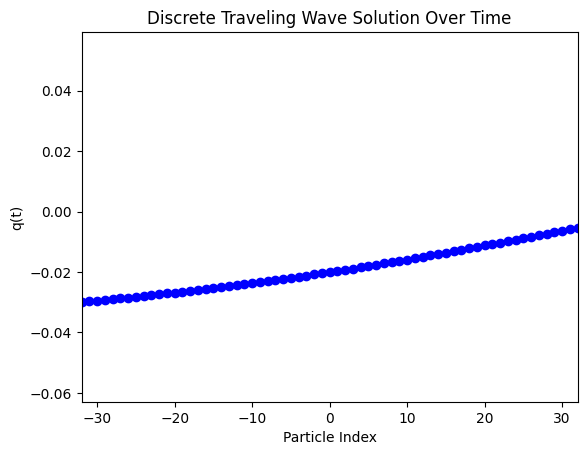

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Constants
time_duration = 100  # Time for simulation in arbitrary units
time_steps = 100     # Number of time steps in the animation

# Generate space and time points for prediction
indices = np.linspace(-N, N, 2 * N + 1)  # particle indices, discretized model
time_values = np.linspace(0, time_duration, time_steps)  # Time domain for the animation

# Prepare input for predictions
test_inputs = np.array([[t, idx] for t in time_values for idx in indices])

# Predict using the trained model
q_predictions, p_predictions = model(test_inputs.astype(np.float32))
q_predictions = q_predictions.numpy().reshape((time_steps, -1))  # Reshape q predictions
p_predictions = p_predictions.numpy().reshape((time_steps, -1))  # Reshape p predictions

# Create the animation for 'q' using dots
fig, ax = plt.subplots()
line, = ax.plot(indices, q_predictions[0, :], 'o', color='b', label='q(t)', lw=2)

def update(frame):
    # Update the data with dots
    line.set_ydata(q_predictions[frame, :])
    return line,

ani = FuncAnimation(fig, update, frames=time_steps, blit=True)
ax.set_xlim([indices.min(), indices.max()])
ax.set_ylim([q_predictions.min() * 1.1, q_predictions.max() * 1.1])
ax.set_xlabel('Particle Index')
ax.set_ylabel('q(t)')
ax.set_title('Discrete Traveling Wave Solution Over Time')

# Save the animation
ani.save('discrete_traveling_wave.gif', writer='pillow', fps=15)

plt.show()

In [14]:
snn_value = model.characteristic_layer.snn.numpy()
print(f'The trained value of snn is: {snn_value}')

The trained value of snn is: 0.8538663983345032


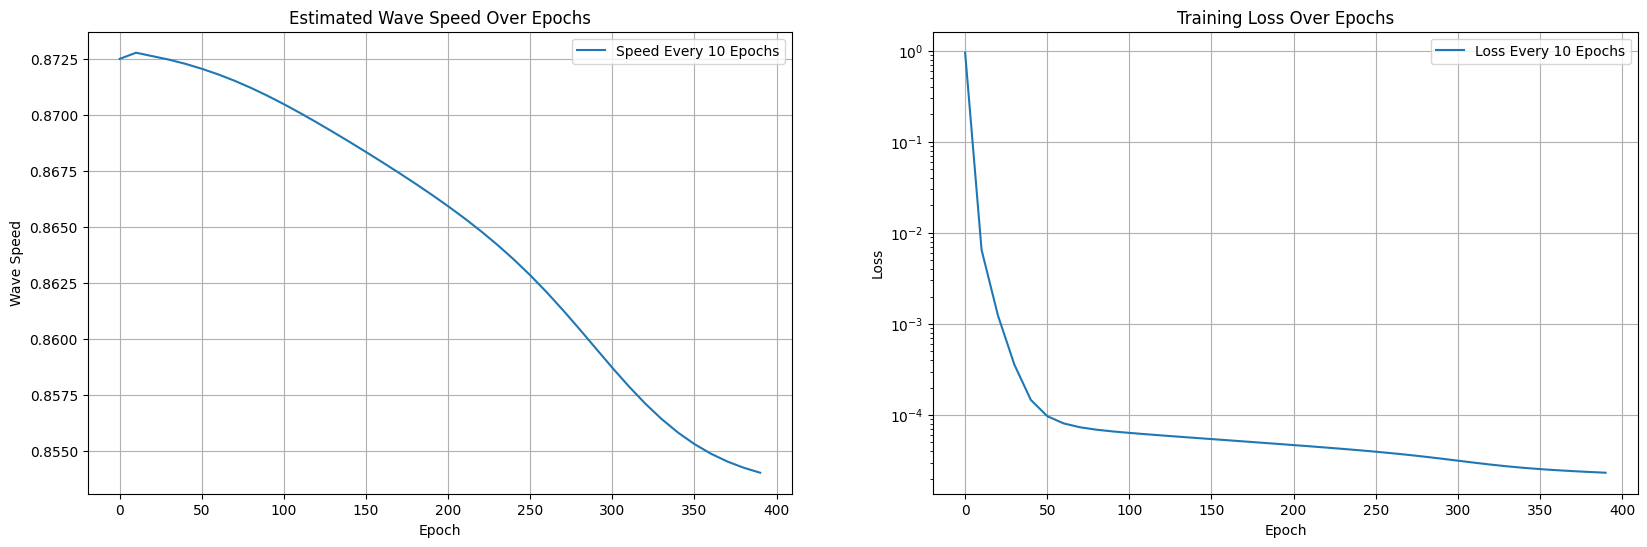

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Estimated Wave Speed
ax1.plot(range(0, len(speed_history)*10, 10), speed_history, label='Speed Every 10 Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Wave Speed')
ax1.set_title('Estimated Wave Speed Over Epochs')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(range(0, len(loss_history)*10, 10), loss_history, label='Loss Every 10 Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Training Loss Over Epochs')
ax2.legend()
ax2.grid(True)

plt.savefig('combined_plots.png')
plt.show()